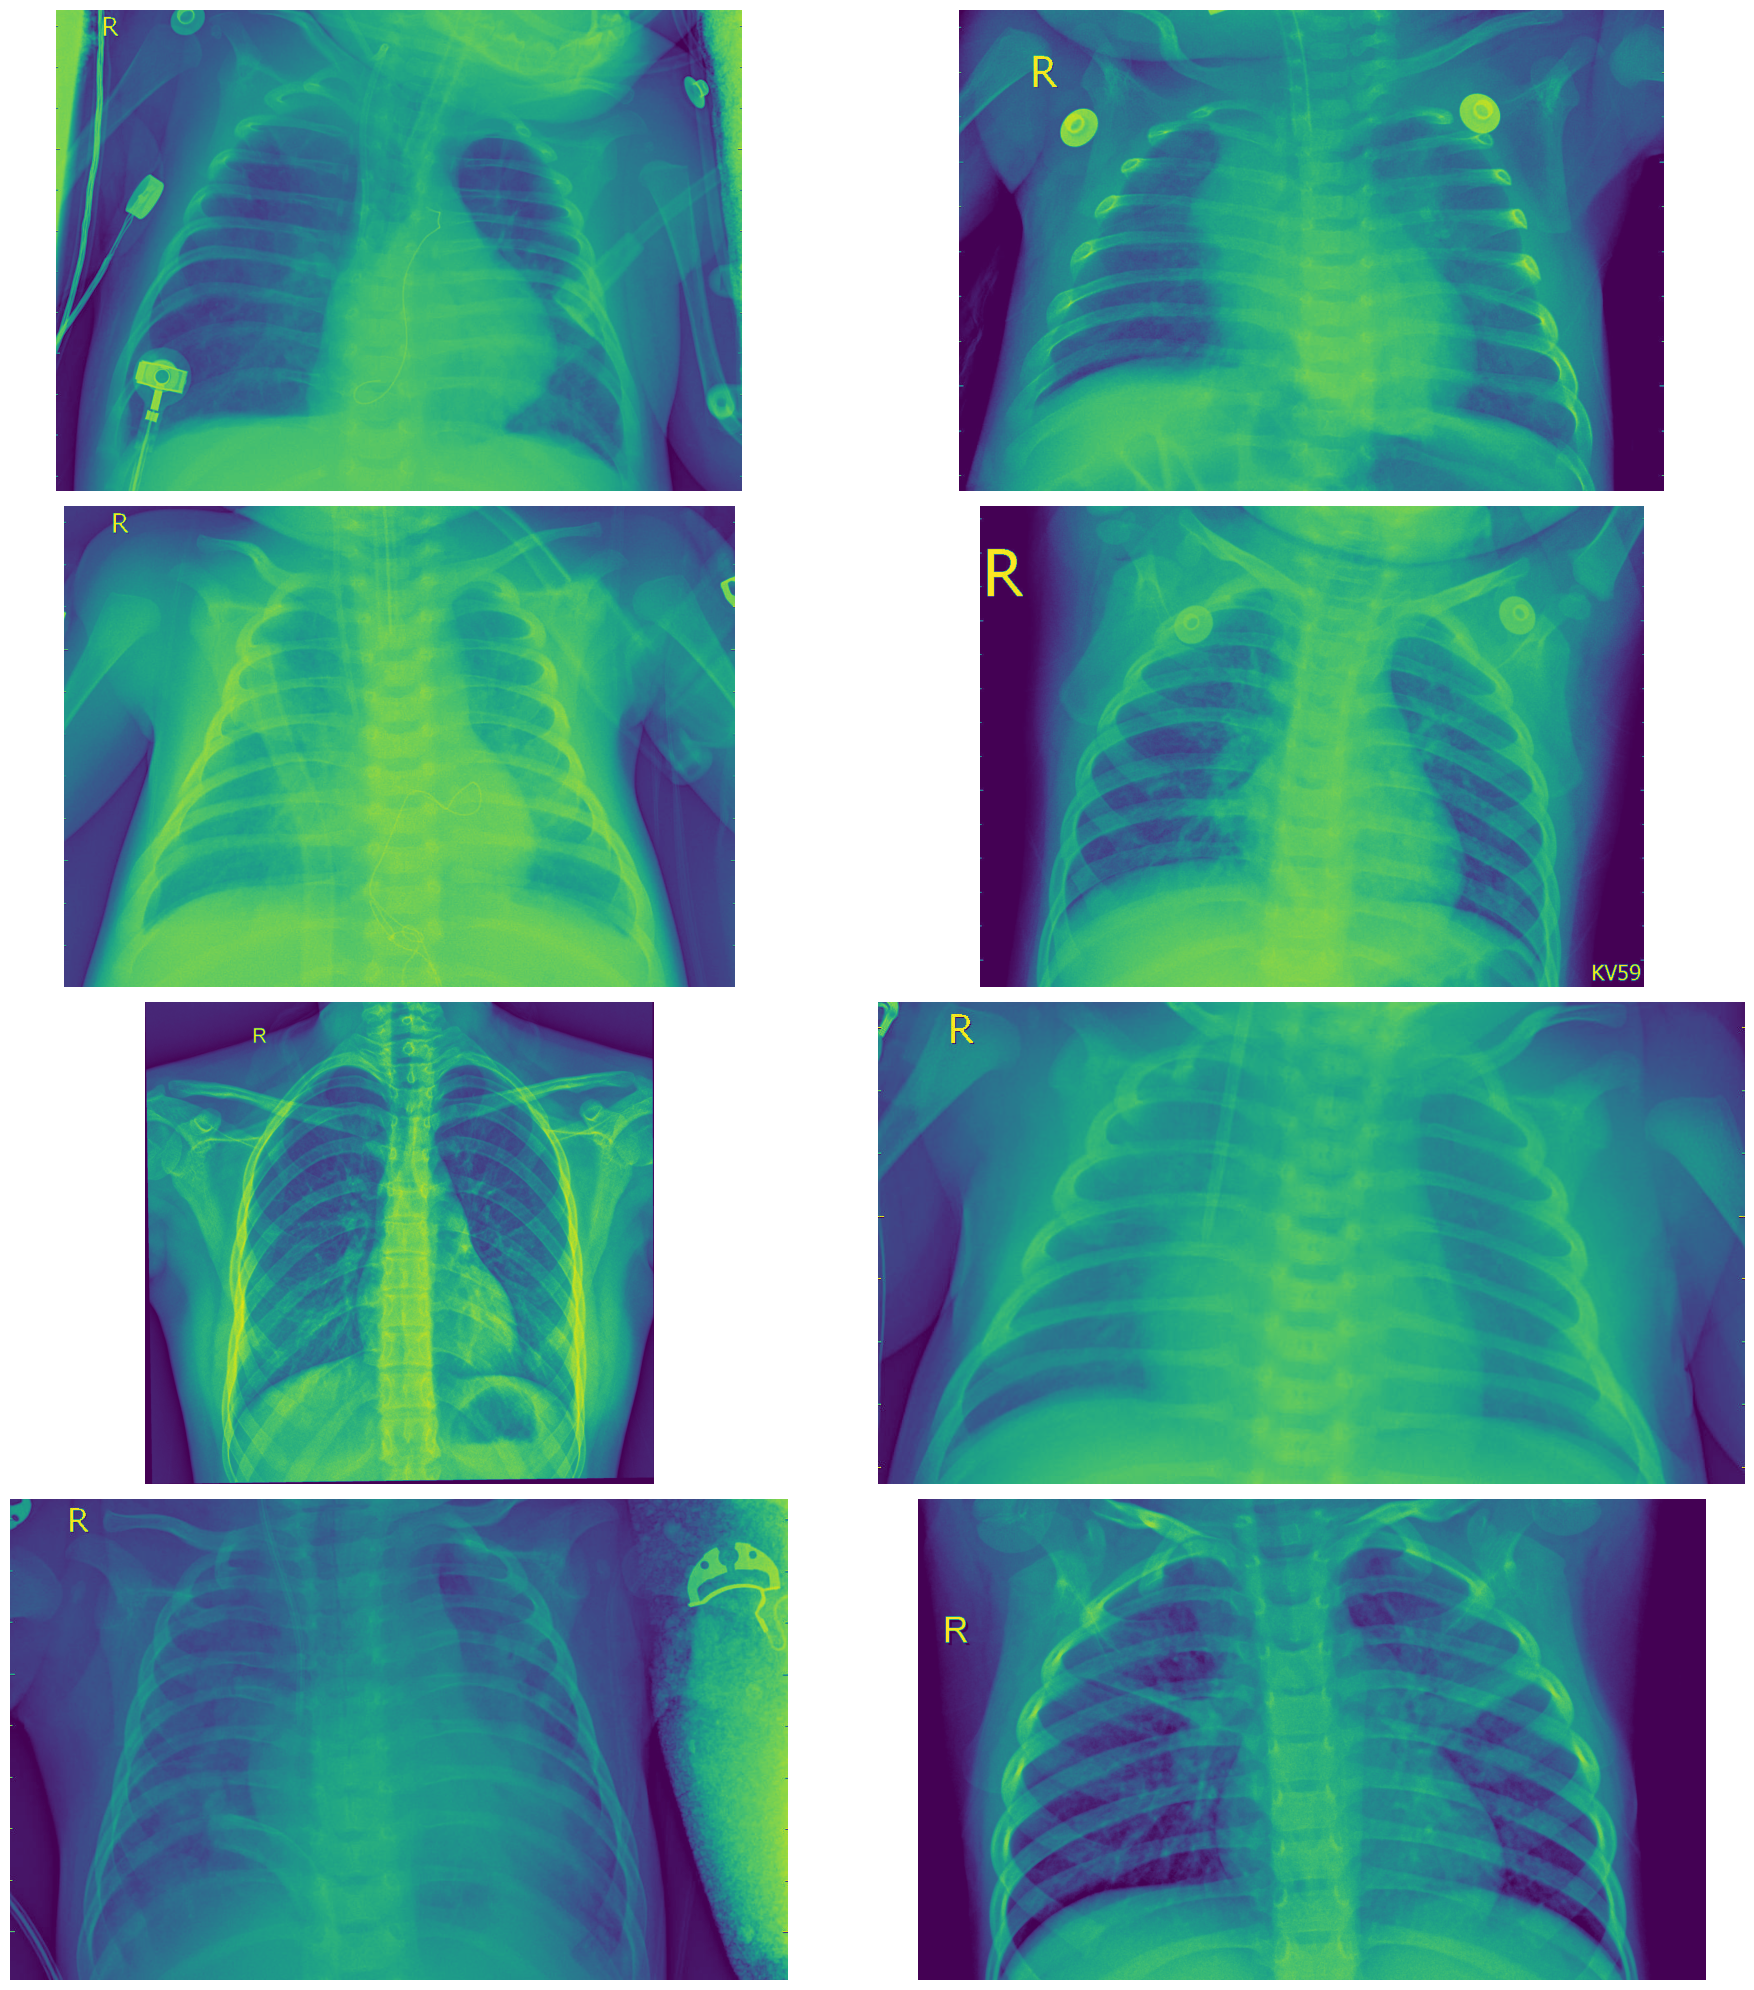

In [13]:
import os
import numpy as np
import random
import cv2

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.utils import to_categorical
import pandas as pd
from PIL import Image

PATH = os.path.join(os.path.dirname("Coronahack-Chest-XRay-Dataset"), 'Coronahack-Chest-XRay-Dataset')

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

batch_size = 32
image_size = (224, 224)

summary = pd.read_csv('Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_dataset_Summary.csv')
metadata = pd.read_csv('Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_Metadata.csv')

train_data = metadata[metadata['Dataset_type'] == 'TRAIN']

train_data=train_data.fillna('n/a')

sample_train_images = list(os.walk(train_dir))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_dir, x), sample_train_images))

plt.figure(figsize=(20, 20))

for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4, 2, iterator+1)
    plt.axis('off')
    plt.imshow(image)


plt.tight_layout()


In [15]:
balanced_data=train_data[(train_data['Label']=='Normal')|
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]

In [16]:
balanced_data['target'] =['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]

/var/folders/c4/3jglbg_j21561_3vqy9lrg8m0000gn/T/ipykernel_30721/267480357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_data['target'] =['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]


In [17]:
from sklearn.utils import shuffle
balanced_data_subset_normal=balanced_data[balanced_data['target']=='negative']
balanced_data_subset_covid=balanced_data[balanced_data['target']=='positive']
balanced_data_frac_normal = balanced_data_subset_normal.sample(frac=(1/5))

balanced_data_concat = pd.concat([balanced_data_frac_normal, balanced_data_subset_covid], axis=0)
balanced_data_concat = shuffle(balanced_data_concat, random_state=0)
balanced_data_train = balanced_data_concat[:240]
balanced_data_validation = balanced_data_concat[240:]

In [18]:
train_data = train_data[(train_data['Label'] == 'Normal') |
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]
train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in train_data['Label']]

train_data = shuffle(train_data, random_state=1)

validation_data = train_data.iloc[1000:, :]

In [19]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)
train_generator = train_image_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=train_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=validation_data,
    directory=train_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

Found 1400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [20]:
def schedule(epoch):
    if epoch<5:
        return 0.0001
    else:
        print('learning rate')
        return  0.0001 * np.exp(0.5 * (5 - epoch))

In [21]:
from keras.metrics import *
from keras.callbacks import LearningRateScheduler
custom_callback = LearningRateScheduler(schedule)

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
]

In [22]:
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Sequential

model=Sequential([
Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
MaxPooling2D((3,3)),
Conv2D(32,(3,3),activation='relu'),
MaxPooling2D((3,3)),
Conv2D(32,(3,3),activation='relu'),
Flatten(),
Dense(64,activation='relu'),
Dropout(0.2),
Dense(16,activation='relu'),
Dropout(0.2),
Dense(1,activation='sigmoid')])

In [23]:
from keras.src.optimizers import Adam
from keras.losses import binary_crossentropy

model.compile(optimizer=Adam(),loss=binary_crossentropy,metrics=METRICS)

In [24]:

history=model.fit_generator(train_generator,validation_data=validation_generator,epochs=10,callbacks=[custom_callback])

/var/folders/c4/3jglbg_j21561_3vqy9lrg8m0000gn/T/ipykernel_30721/2008133174.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,validation_data=validation_generator,epochs=10,callbacks=[custom_callback])
/Users/luiz.silva/projects/cognitivecomputing/venv/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/Users/luiz.silva/projects/cognitivecomputing/venv/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
175/175 [==============================] - 40s 227ms/step - loss: 0.3539 - tp: 10.0000 - fp: 268.0000 - tn: 1074.0000 - fn: 48.0000 - accuracy: 0.7743 - precision: 0.0360 - recall: 0.1724 - val_loss: 0.2263 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
175/175 [==============================] - 41s 233ms/step - loss: 0.2989 - tp: 8.0000 - fp: 221.0000 - tn: 1121.0000 - fn: 50.0000 - accuracy: 0.8064 - precision: 0.0349 - recall: 0.1379 - val_loss: 0.2021 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
175/175 [==============================] - 47s 266ms/step - loss: 0.2676 - tp: 1.0000 - fp: 114.0000 - tn: 1228.0000 - fn: 57.0000 - accuracy: 0.8779 - precision: 0.0087 - recall: 0.0172 - val_loss: 0.1736 - va

/Users/luiz.silva/projects/cognitivecomputing/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/luiz.silva/projects/cognitivecomputing/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/luiz.silva/projects/cognitivecomputing/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luiz.silva/projects/cognitivecomputing/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWar

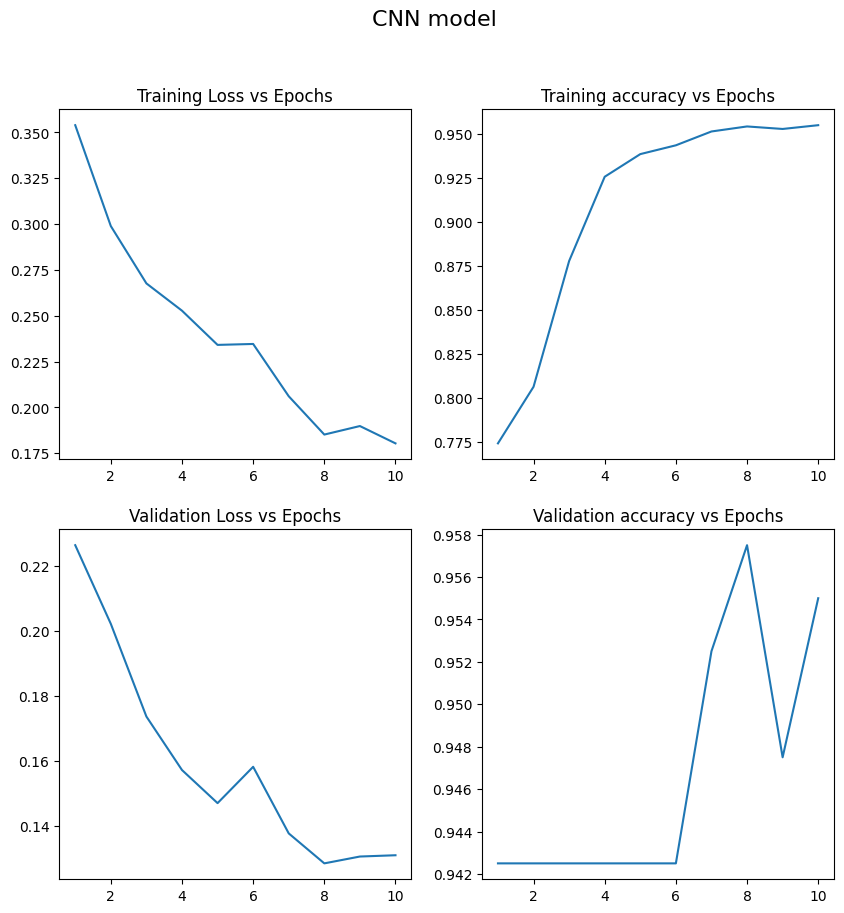

In [26]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 11), y=history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 11), y=history.history.get('accuracy'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 11), y=history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 11), y=history.history.get('val_accuracy'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training accuracy vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation accuracy vs Epochs')
fig.suptitle('CNN model', size=16)
plt.show()